In [2]:
import os
from utils import utils

"""
00 - Configuration
"""

dataset_zip_path = "../../data_warehouse/warehouse_3/snapshots/"
output_folder = "../../data_warehouse/minimized_warehouse_3/"

zip_files_list = utils.list_zip_files(dataset_zip_path)

print("List of zip files:")
for zip_file in zip_files_list:
    print(zip_file)


List of zip files:
1735647513_(2.1000).zip
1735648326_(2.5000).zip
1735645847_(1.5000).zip
1735652627_(4.10000).zip
1735651459_(4.5000).zip
1735650171_(3.10000).zip
1735647009_(1.10000).zip
1735653296_(5.10000).zip
1735649744_(3.1000).zip
1735650657_(4.1000).zip
1735645043_(1.1000).zip
1735655731_(6.10000).zip
1735654578_(6.5000).zip
1735649502_(2.10000).zip
1735653082_(5.5000).zip
1735652869_(5.1000).zip
1735653779_(6.1000).zip
1735649957_(3.5000).zip


In [3]:
"""
01 - Process qos metrics from .zip files:

- Combine all .csv-files in the given .zip to a DataFrame
- Save the dataframe to output_path
"""


import zipfile
import time
import pandas as pd

failed_zips = []
successful_zips = []

def process_zip(path, output_folder, name="qos_metrics", starts_with=""):
    # Open as zip
    with zipfile.ZipFile(path, 'r') as zip_ref:
    
        # Get a list of all files in the zip
        items = zip_ref.namelist()
    
        # Get a list of all .csv-files in the zip
        csv_files = [x for x in items if x.endswith('.csv')]
        print(csv_files)
        csv_files = [x for x in csv_files if starts_with in x]  # Separate worker_n.csv from master_n.csv
        print(csv_files)
        csv_files.sort(reverse=True)  # NOTE: Sorting does not matter, but may be useful for debugging
        if len(csv_files) == 0:
            print(f"No .csv-files found in {path}")
            failed_zips.append(path)
            return
        
        count = 0
        start_time = time.time()
    
        # Iterate over all csv-files
        dataframes = []
        for path in csv_files:
            count += 1
            print(f"Progress {count}/{len(csv_files):6}, ({count/len(csv_files)*100:5.3} %) (time_spent: {time.time() - start_time:.3} s  - avg: {(time.time() - start_time) / count} s)")
            with zip_ref.open(path) as csv_file:
                x = pd.read_csv(csv_file)
                dataframes.append(x)
        
        # Combine data to a single DataFrame
        df = pd.concat(dataframes)
        os.makedirs(output_folder, exist_ok=True)
        output_path = os.path.join(output_folder, f"{name}.feather")
        df.sort_index(inplace=True)
        df.reset_index(drop=False, inplace=True, names=["timestamp"])
        df.to_feather(output_path)
        print(f"Saved to {output_path}")
        successful_zips.append(output_path)
        return df

dfs = []
titles = []
for application_type in ["master", "worker"]:
    if dataset_zip_path.endswith(".zip"):
        # Process single zip
        print(f"Processing {dataset_zip_path}")
        df = process_zip(dataset_zip_path, output_folder, name=f"{application_type}_qos", starts_with=application_type)
        dfs.append(df)
        zip_name = dataset_zip_path.split('/')[-1].replace(".zip", "")
        titles.append(zip_name)
    else:
        # Process all zips in path
        for zip_name_full in utils.list_zip_files(dataset_zip_path):
            print(zip_name_full)
            zip_name = zip_name_full.replace(".zip", "")
            full_output_path = f"{output_folder}/{zip_name}"
            df = process_zip(dataset_zip_path + zip_name_full, full_output_path, name=f"{application_type}_qos", starts_with=application_type)
            dfs.append(df)
            titles.append(zip_name)

print(f"Failed zips:")
for zip_name in failed_zips:
    print(zip_name)

print("")
print(f"Successful zips:")
for zip_name in successful_zips:
    print(zip_name)

1735647513_(2.1000).zip
['qos_outputs_0/master_3.csv', 'qos_outputs_0/master_9.csv', 'qos_outputs_0/worker_8.csv', 'qos_outputs_0/worker_5.csv', 'qos_outputs_0/master_0.csv', 'qos_outputs_0/worker_10.csv', 'qos_outputs_0/worker_9.csv', 'qos_outputs_0/master_1.csv', 'qos_outputs_0/master_7.csv', 'qos_outputs_0/worker_6.csv', 'qos_outputs_0/master_8.csv', 'qos_outputs_0/master_6.csv', 'qos_outputs_0/worker_7.csv', 'qos_outputs_0/master_2.csv', 'qos_outputs_0/worker_1.csv', 'qos_outputs_0/master_5.csv', 'qos_outputs_0/master_4.csv', 'qos_outputs_0/worker_4.csv', 'qos_outputs_0/worker_0.csv', 'qos_outputs_0/worker_3.csv', 'qos_outputs_0/worker_2.csv']
['qos_outputs_0/master_3.csv', 'qos_outputs_0/master_9.csv', 'qos_outputs_0/master_0.csv', 'qos_outputs_0/master_1.csv', 'qos_outputs_0/master_7.csv', 'qos_outputs_0/master_8.csv', 'qos_outputs_0/master_6.csv', 'qos_outputs_0/master_2.csv', 'qos_outputs_0/master_5.csv', 'qos_outputs_0/master_4.csv']
Progress 1/    10, ( 10.0 %) (time_spent: 8

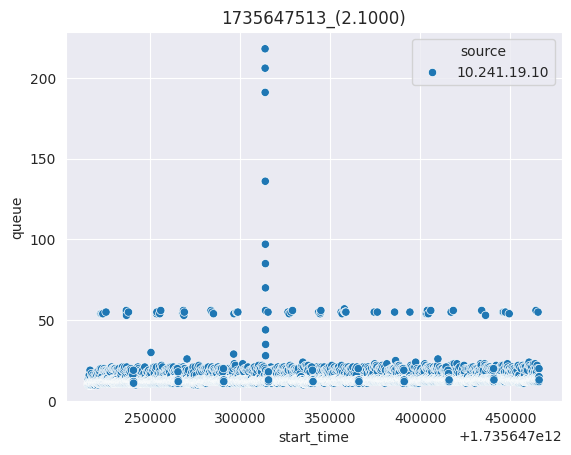

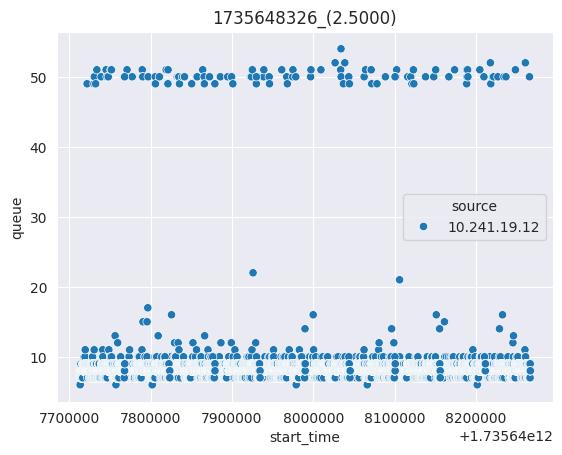

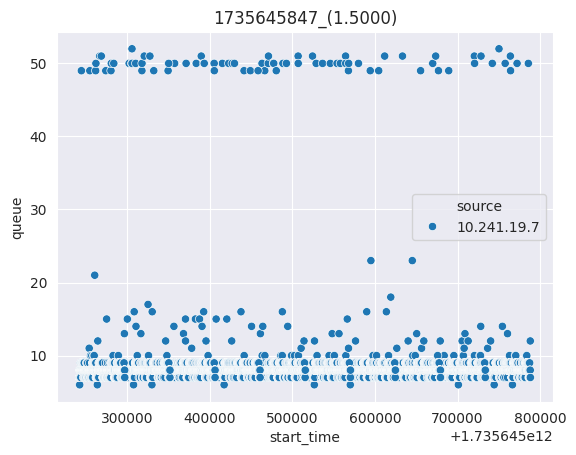

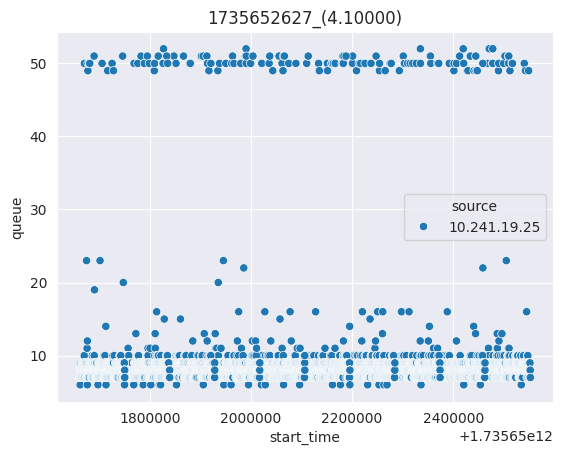

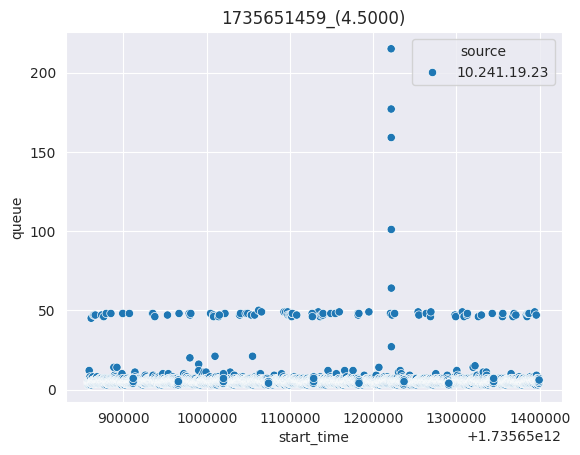

ValueError: Could not interpret value `start_time` for `x`. Value is a string, but `data` was not passed.

In [4]:
"""
Quick plot to partially visualize the data.
"""
import seaborn as sns
import matplotlib.pyplot as plt
for i, df in enumerate(dfs):
    sns.scatterplot(y="queue", x="start_time", hue="source", data=df)
    plt.title(titles[i])
    plt.show()
    # sns.scatterplot(y="queue", x="Unnamed: 0", data=df)
    # plt.savefig("yolo_queue.png")
    # df.plot.scatter(y=df.queue, x=df.index)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
for i, df in enumerate(dfs):
    df2 = df.copy()
    df2["q"] = df2["end_time"] - df2["start_time"]
    sns.scatterplot(y="q", x="start_time", hue="source", data=df2)
    plt.ylim(0,200)
    plt.title(titles[i])
    plt.show()
    # sns.scatterplot(y="queue", x="Unnamed: 0", data=df)
    # plt.savefig("yolo_queue.png")
    # df.plot.scatter(y=df.queue, x=df.index)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
for i, df in enumerate(dfs):
    df2 = df.copy()
    df2["q"] = df2["end_time"] - df2["start_time"]
    sns.ecdfplot(y="start_time", hue="source", data=df2)
    plt.title(titles[i])
    plt.show()
    sns.ecdfplot(y="end_time", hue="source", data=df2)
    plt.title(titles[i])
    plt.show()
    sns.ecdfplot(y="q", hue="source", data=df2)
